# Tardis Model Training

This notebook contains the code for loading the cleaned dataset, performing feature engineering, training various regression models to predict train delays, tuning hyperparameters, and saving the best performing model.

In [6]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer # Import SimpleImputer
import joblib
import os
import matplotlib.pyplot as plt
import seaborn as sns

## 1. Load the Cleaned Dataset

In [7]:
# Load the cleaned dataset output from tardis_eda.ipynb
DATA_PATH = "cleaned_dataset.csv"

if not os.path.exists(DATA_PATH):
    print(f"Error: Cleaned dataset not found at {DATA_PATH}. Please run tardis_eda.ipynb first.")
else:
    df = pd.read_csv(DATA_PATH)
    print(f"Successfully loaded cleaned data with shape: {df.shape}")
    print("\nFirst 5 rows of the cleaned data:")
    print(df.head())

Successfully loaded cleaned data with shape: (10662, 26)

First 5 rows of the cleaned data:
         Date   Service   Departure station      Arrival station  \
0  2018-01-01  National    BORDEAUX ST JEAN   PARIS MONTPARNASSE   
1  2018-01-01  National   LA ROCHELLE VILLE   PARIS MONTPARNASSE   
2  2018-01-01  National  PARIS MONTPARNASSE              QUIMPER   
3         NaN  National  PARIS MONTPARNASSE              ST MALO   
4  2018-01-01  National  PARIS MONTPARNASSE  ST PIERRE DES CORPS   

   Average journey time  Number of scheduled trains  \
0                 141.0                         NaN   
1                 165.0                       222.0   
2                 220.0                       248.0   
3                 156.0                       102.0   
4                  61.0                       391.0   

   Number of cancelled trains  Cancellation comments  \
0                         5.0                    NaN   
1                         NaN                    NaN   


## 2. Feature Engineering

In [8]:
# Ensure df exists from the previous cell
if 'df' in locals():
    # Convert 'Date' to datetime and extract features
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    df['Hour'] = df['Date'].dt.hour
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['Month'] = df['Date'].dt.month
    print("\nCreated Hour, DayOfWeek, and Month features.")

    # Define features and target variable
    features = [
        "Departure station",
        "Arrival station",
        "Hour",
        "DayOfWeek",
        "Month",
        "Number of scheduled trains",
        "Number of cancelled trains",
        # Add percentage delay columns as features if they exist
    ] + [col for col in df.columns if 'Pct delay' in col]

    target = "Average delay of all trains at arrival"

    # Drop rows with missing target values and select relevant columns
    df_model = df.dropna(subset=[target]).copy() # Create a copy to avoid SettingWithCopyWarning

    # Filter features to only include those present in the dataframe after dropping NaNs
    available_features = [feat for feat in features if feat in df_model.columns]
    df_model = df_model[available_features + [target]]

    if target in df_model.columns:
        print(f"\nSelected features: {available_features}")
        print(f"Target variable: {target}")
        print(f"Shape after dropping rows with missing target values: {df_model.shape}")

        # Separate X and y
        X = df_model[available_features].copy() # Create a copy of X
        y = df_model[target].copy() # Create a copy of y
        print(f"\nShape of X before processing: {X.shape}")
        print(f"Shape of y: {y.shape}")

        # Identify categorical and numerical columns
        categorical_cols = [col for col in ["Departure station", "Arrival station"] if col in X.columns]
        numerical_cols = [col for col in X.columns if col not in categorical_cols]

        # Apply One-hot encoding to categorical features
        if categorical_cols:
            ohe = OneHotEncoder(handle_unknown="ignore")
            X_cat = ohe.fit_transform(X[categorical_cols]).toarray()
            X_cat_df = pd.DataFrame(X_cat, columns=ohe.get_feature_names_out(categorical_cols), index=X.index)
            print(f"Shape after one-hot encoding categorical features: {X_cat_df.shape}")
        else:
            X_cat_df = pd.DataFrame(index=X.index) # Create an empty DataFrame to concatenate

        # Apply Imputation to numerical features
        if numerical_cols:
            imputer = SimpleImputer(strategy='mean') # Or 'median', 'most_frequent'
            X_num_imputed = imputer.fit_transform(X[numerical_cols])
            X_num_imputed_df = pd.DataFrame(X_num_imputed, columns=numerical_cols, index=X.index)
            print(f"Shape after imputing numerical features: {X_num_imputed_df.shape}")
        else:
            X_num_imputed_df = pd.DataFrame(index=X.index) # Create an empty DataFrame to concatenate


        # Concatenate the processed numerical and categorical features
        X_final = pd.concat([X_num_imputed_df, X_cat_df], axis=1)
        print(f"Shape of X_final after processing: {X_final.shape}")
        print("First 5 rows of the final feature set:")
        print(X_final.head())

    else:
        print(f"Error: Target column '{target}' not found in the dataframe after dropping NaNs.")
else:
    print("Error: DataFrame 'df' not found. Please run the data loading cell first.")



Created Hour, DayOfWeek, and Month features.

Selected features: ['Departure station', 'Arrival station', 'Hour', 'DayOfWeek', 'Month', 'Number of scheduled trains', 'Number of cancelled trains', 'Pct delay due to external causes', 'Pct delay due to infrastructure', 'Pct delay due to traffic management', 'Pct delay due to rolling stock', 'Pct delay due to station management and equipment reuse', 'Pct delay due to passenger handling (crowding, disabled persons, connections)']
Target variable: Average delay of all trains at arrival
Shape after dropping rows with missing target values: (9749, 14)

Shape of X before processing: (9749, 13)
Shape of y: (9749,)
Shape after one-hot encoding categorical features: (9749, 120)
Shape after imputing numerical features: (9749, 11)
Shape of X_final after processing: (9749, 131)
First 5 rows of the final feature set:
   Hour  DayOfWeek    Month  Number of scheduled trains  \
0   0.0   0.000000  1.00000                  395.907846   
1   0.0   0.00000

## 3. Train/Test Split

In [9]:
# Ensure X_final and y exist from the previous cell
if 'X_final' in locals() and 'y' in locals():
    X_train, X_test, y_train, y_test = train_test_split(
        X_final, y, test_size=0.2, random_state=42
    )

    print(f"\nShape of training data (X_train): {X_train.shape}")
    print(f"Shape of testing data (X_test): {X_test.shape}")
    print(f"Shape of training labels (y_train): {y_train.shape}")
    print(f"Shape of testing labels (y_test): {y_test.shape}")
else:
    print("Cannot perform train/test split: Feature set or target variable not available.")


Shape of training data (X_train): (7799, 131)
Shape of testing data (X_test): (1950, 131)
Shape of training labels (y_train): (7799,)
Shape of testing labels (y_test): (1950,)


## 4. Train and Evaluate Models

In [10]:
# Ensure train/test data exists from the previous cell
if 'X_train' in locals() and 'X_test' in locals() and 'y_train' in locals() and 'y_test' in locals():
    def evaluate_model(model, X_train, y_train, X_test, y_test, name):
        print(f"\nTraining {name}...")
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        print(f"{name}: RMSE={rmse:.2f}, R^2={r2:.3f}")
        return rmse, r2, model


    results = []

    # Linear Regression
    lr = LinearRegression()
    results.append(
        (
            *evaluate_model(lr, X_train, y_train, X_test, y_test, "Linear Regression"),
            "Linear Regression",
        )
    )

    # Decision Tree
    dt = DecisionTreeRegressor(random_state=42)
    results.append(
        (
            *evaluate_model(dt, X_train, y_train, X_test, y_test, "Decision Tree"),
            "Decision Tree",
        )
    )

    # Random Forest
    rf = RandomForestRegressor(random_state=42)
    results.append(
        (
            *evaluate_model(rf, X_train, y_train, X_test, y_test, "Random Forest"),
            "Random Forest",
        )
    )

else:
    print("Cannot train models: Train/test data not available.")


Training Linear Regression...
Linear Regression: RMSE=12.42, R^2=0.005

Training Decision Tree...
Decision Tree: RMSE=17.77, R^2=-1.036

Training Random Forest...
Random Forest: RMSE=12.64, R^2=-0.030


## 5. Hyperparameter Tuning for Random Forest

In [11]:
# Ensure train data and initial results exist
if 'X_train' in locals() and 'y_train' in locals() and 'results' in locals():
    print("\nPerforming GridSearchCV for Random Forest...")
    param_grid = {"n_estimators": [50, 100, 200], "max_depth": [5, 10, 20, None]}
    gs = GridSearchCV(
        RandomForestRegressor(random_state=42),
        param_grid,
        cv=3,
        scoring="neg_root_mean_squared_error", # Use negative RMSE for scoring
        n_jobs=-1,
    )
    gs.fit(X_train, y_train)

    print(f"\nBest Random Forest params: {gs.best_params_}")
    results.append(
        (
            *evaluate_model(
                gs.best_estimator_, X_train, y_train, X_test, y_test, "Tuned Random Forest"
            ),
            "Tuned Random Forest",
        )
    )

else:
    print("Cannot perform hyperparameter tuning: Train data or initial results not available.")


Performing GridSearchCV for Random Forest...

Best Random Forest params: {'max_depth': 10, 'n_estimators': 200}

Training Tuned Random Forest...
Tuned Random Forest: RMSE=12.51, R^2=-0.009


## 6. Compare Models and Save Best Model

In [12]:
# Ensure results exist from previous steps
if 'results' in locals() and results:
    print("\n--- Model Comparison --- ")
    for rmse, r2, model, name in results:
         print(f"{name}: RMSE={rmse:.2f}, R^2={r2:.3f}")

    # sort by RMSE (index 0)
    results_sorted = sorted(results, key=lambda x: x[0])  

    best_model = results_sorted[0][2]
    best_name = results_sorted[0][3]

    print(f"\nBest model: {best_name}")

    # Save the best model and the OneHotEncoder
    MODEL_SAVE_PATH = "best_delay_predictor.joblib"
    OHE_SAVE_PATH = "one_hot_encoder.joblib"

    joblib.dump(best_model, MODEL_SAVE_PATH)
    print(f"Best model saved as {MODEL_SAVE_PATH}")

    # Check if ohe was created (only if categorical features were present)
    if 'ohe' in locals():
       joblib.dump(ohe, OHE_SAVE_PATH)
       print(f"OneHotEncoder saved as {OHE_SAVE_PATH}")
    else:
        print("OneHotEncoder not saved as no categorical features were encoded.")


else:
    print("Cannot compare or save models: Results not available.")


--- Model Comparison --- 
Linear Regression: RMSE=12.42, R^2=0.005
Decision Tree: RMSE=17.77, R^2=-1.036
Random Forest: RMSE=12.64, R^2=-0.030
Tuned Random Forest: RMSE=12.51, R^2=-0.009

Best model: Linear Regression
Best model saved as best_delay_predictor.joblib
OneHotEncoder saved as one_hot_encoder.joblib


## 7. Model Diagnostics Visualization


Generating Model Diagnostics Plot...
Model diagnostics plot saved to visualizations/model_diagnostics/predictions_vs_actuals.png


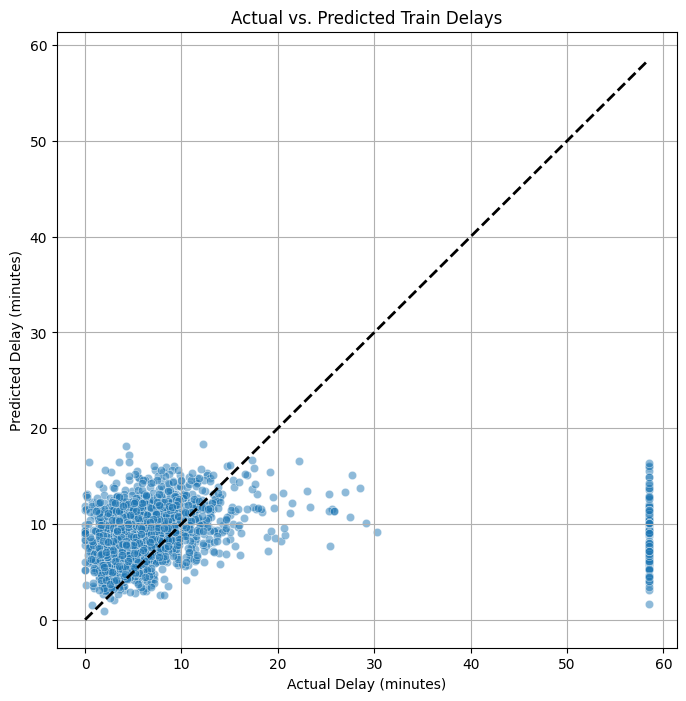

In [13]:
# Ensure best_model, X_test, and y_test exist
if 'best_model' in locals() and 'X_test' in locals() and 'y_test' in locals():
    print("\nGenerating Model Diagnostics Plot...")

    # Make predictions on the test set
    y_pred = best_model.predict(X_test)

    # Create the directory for saving plots if it doesn't exist
    plot_dir = "visualizations/model_diagnostics"
    os.makedirs(plot_dir, exist_ok=True)

    # Create a scatter plot of actual vs. predicted values
    plt.figure(figsize=(8, 8))
    sns.scatterplot(x=y_test, y=y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2) # Add a diagonal line for perfect predictions
    plt.xlabel("Actual Delay (minutes)")
    plt.ylabel("Predicted Delay (minutes)")
    plt.title("Actual vs. Predicted Train Delays")
    plt.grid(True)

    # Save the plot as a PNG file
    plot_save_path = os.path.join(plot_dir, "predictions_vs_actuals.png")
    plt.savefig(plot_save_path)
    print(f"Model diagnostics plot saved to {plot_save_path}")

    # Display the plot (optional in a script, useful in a notebook)
    plt.show()

else:
    print("Cannot generate model diagnostics plot: Best model or test data not available.")
